# Feature Engineering and Modelling

## Steps:

1. Import packages
2. Load data
3. Feature engineering
4. Build Predictive Models

## 1. Import packages

In [56]:
#import the necessary libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore") 

## 2. Load data

In [58]:
date_cols=['date_activ','date_end','date_modif_prod','date_renewal']
df = pd.read_csv('clean_data_modeling.csv',parse_dates=date_cols)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,8.182687,12.311304,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.000000,0.088409,0
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,16.365274,24.539003,0


This data consists of PowerCo's churn information which mean customer will switch to another provider or not. The final column in the dataset (Churn) contains the value 0 for customer who doesn't churn, and 1 for patients who churns. This is the label that we will train our model to predict; other columns are the features we will use to predict the Churn label.

Now, Train a binary classifier to predict whether or not a customer should be churn based on some historical data. But according to task requirements, a Random Forest classifier will used to predict customer churn and evaluate the performance of the model with suitable evaluation metrics.

For tree-based models, there is no need to perform data scaling, unlike other machine learning models. And dont need to apply one-hot encoding to processing categorical variables, just use label-encoding to convert categorical variables to numeric variables.

In [60]:
df.drop(columns = 'Unnamed: 0', inplace=True) #drop the Unnamed column

In [61]:
df.shape #check the shape of the dataset

(14605, 53)

There are 53 columns and 14605 rows. 

In [63]:
df.dtypes

id                                        object
channel_sales                             object
cons_12m                                   int64
cons_gas_12m                               int64
cons_last_month                            int64
date_activ                        datetime64[ns]
date_end                          datetime64[ns]
date_modif_prod                   datetime64[ns]
date_renewal                      datetime64[ns]
forecast_cons_12m                        float64
forecast_cons_year                         int64
forecast_discount_energy                 float64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                   object
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64
nb_prod_act         

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

In [66]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [67]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [68]:
monthly_price_by_id.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [69]:
jan_prices.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-01-01,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-01-01,0.150837,44.444710
3,0010ee3855fdea87602a5b7aba8e42de,2015-01-01,0.123086,40.565969
4,00114d74e963e47177db89bc70108537,2015-01-01,0.149434,44.266931


In [70]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.036909,42.497907,12.218665,8.145777,42.629663,8.182687,12.311304,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.000000,0.088409,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073719,40.728885,24.437330,16.291555,40.848791,16.365274,24.539003,0,-0.006192,0.162916


In the dataset, we have some datetime features: 
-  date_activ = date of activation of the contract
-  date_end = registered date of the end of the contract
-  date_modif_prod = date of the last modification of the product
-  date_renewal = date of the next contract renewal

From these features, we can create new columns called:
- tenure: the time customer uses service of PowerCo
- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
-  months_renewal = Number of months since last renewal until reference date (Jan 2016)


In [72]:
# We no longer need the datetime columns so we can drop them

remove = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.036909,42.497907,12.218665,8.145777,42.629663,8.182687,12.311304,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.000000,0.088409,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.073719,40.728885,24.437330,16.291555,40.848791,16.365274,24.539003,0,-0.006192,0.162916


### Transform Categorical Data

We have 3 categorical variables including: has_gas, channel_sales, origin_up. 

In [75]:
#For the column has_gas, replace t for 1 and f for 0
df['has_gas']=df['has_gas'].replace(['t','f'],[1,0])

Let's check values of the two others. 

In [77]:
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [78]:
df['origin_up'].value_counts()


origin_up
lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

There is imbalance in the number of values for channel_sales and origin_up so we will remove the values with very little occurences comparing with others.  

In [80]:
#One hot encoding using get_dummies()
df = pd.get_dummies(df, columns = ['channel_sales', 'origin_up'])

In [81]:
df.head()


,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_MISSING,origin_up_ewxeelcelemmiwuafmddpobolfuxioce,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,True,False,False,False,False,False,False,False,True,False
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,False,False,False,False,False,False,True,False,False,False
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,True,False,False,False,False,False,True,False,False,False
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,False,True,False,False,False,False,True,False,False,False
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,False,False,False,False,False,False,True,False,False,False


In [82]:
#remove values with very little occurences
df = df.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu','channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
                     'origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])

In [83]:
df.head()


,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,0.020057,3.700961,False,False,True,False,False,False,False,True
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,-0.003767,0.177779,True,False,False,False,False,True,False,False
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,-0.004670,0.177779,False,False,True,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,-0.004547,0.177779,False,False,False,True,False,True,False,False
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,-0.006192,0.162916,True,False,False,False,False,True,False,False


### Transform Numerical Data

From the previous EDA we can see that some features are highly skewed, we need to transform the distribution to normal-like distribution. We will use log transfomation via Numpy  by calling the log() function on the desired column. First, we will check skewed features, so that we can compare before and after transformation

In [86]:
numeric_features = df[[
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]]
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14605.0,159230.267032,573483.629064,0.0,5674.000000,14116.000000,40764.000000,6.207104e+06
cons_gas_12m,14605.0,28091.082506,162978.563803,0.0,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14605.0,16091.371448,64366.262314,0.0,0.000000,793.000000,3383.000000,7.712030e+05
forecast_cons_12m,14605.0,1868.638618,2387.651549,0.0,494.980000,1112.610000,2402.270000,8.290283e+04
forecast_cons_year,14605.0,1399.858747,3247.876793,0.0,0.000000,314.000000,1746.000000,1.753750e+05
forecast_discount_energy,14605.0,0.966450,5.108355,0.0,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14605.0,63.090448,66.166636,0.0,16.180000,18.800000,131.030000,5.993100e+02
forecast_price_energy_off_peak,14605.0,0.137282,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14605.0,0.050488,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01
forecast_price_pow_off_peak,14605.0,43.130085,4.486140,0.0,40.606701,44.311378,44.311378,5.926638e+01


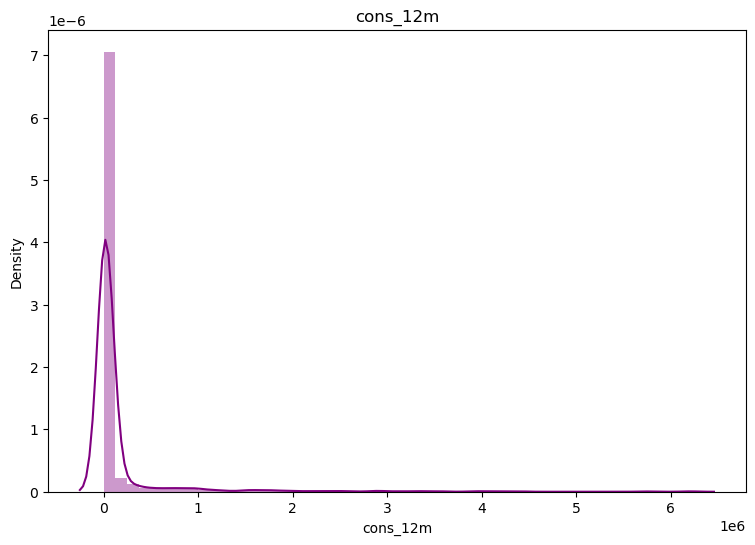

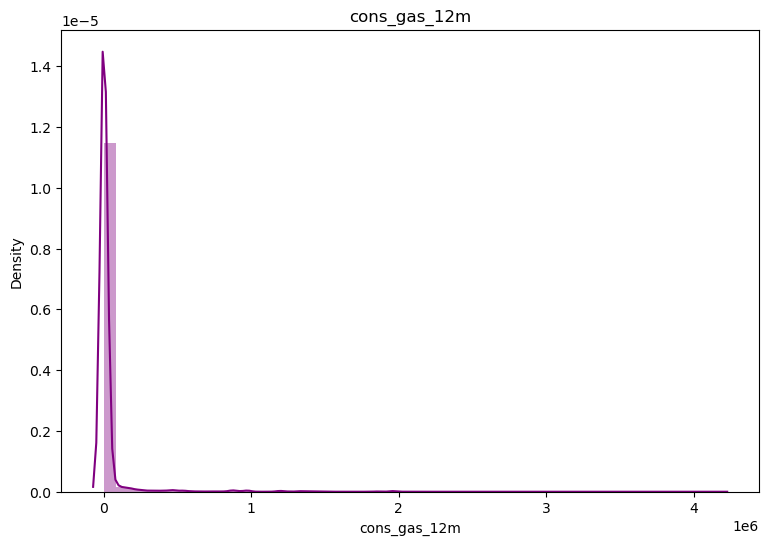

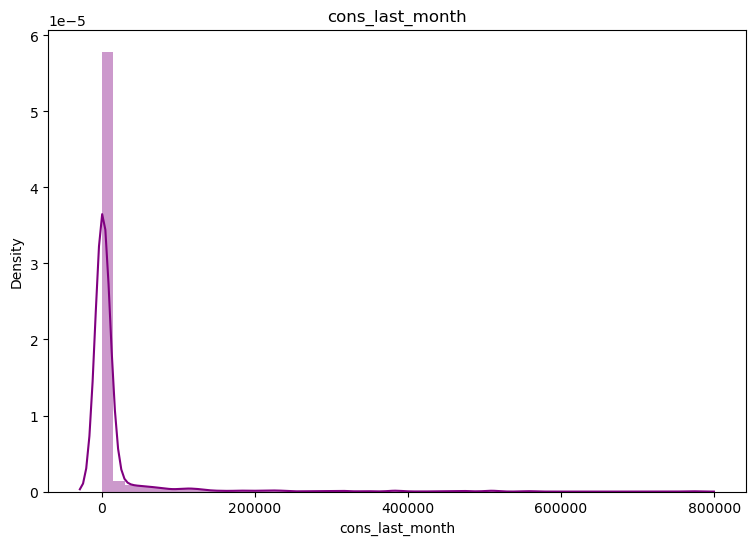

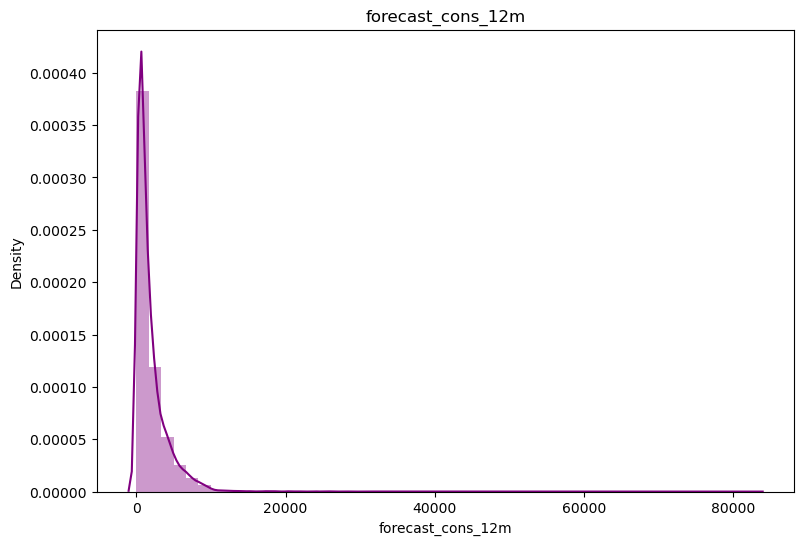

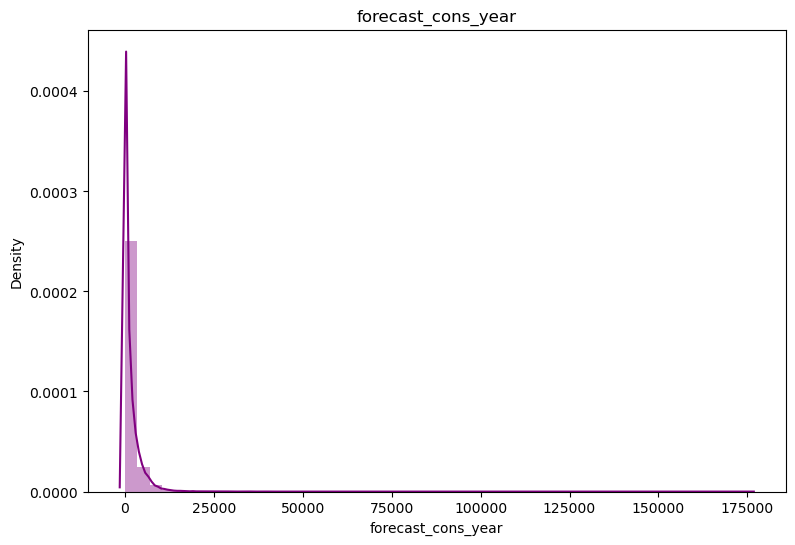

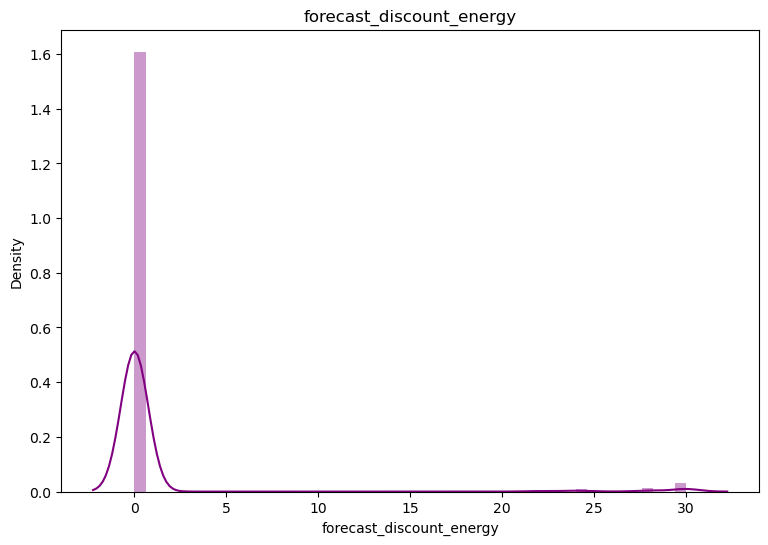

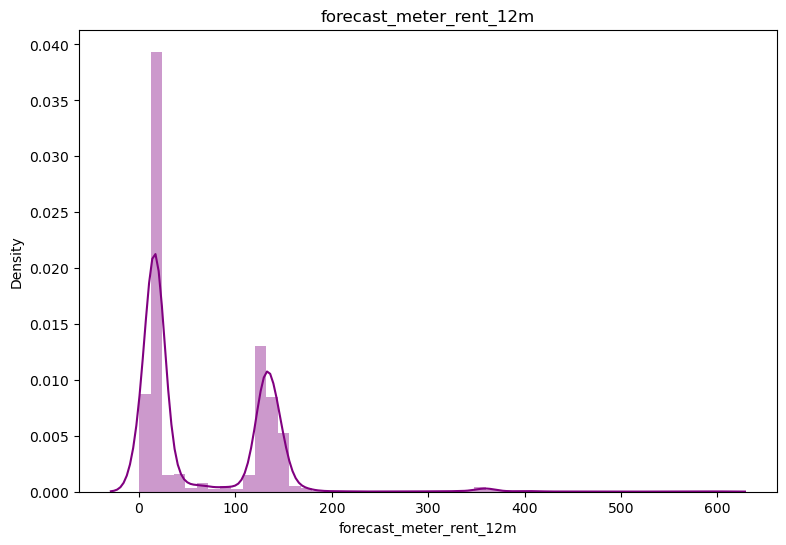

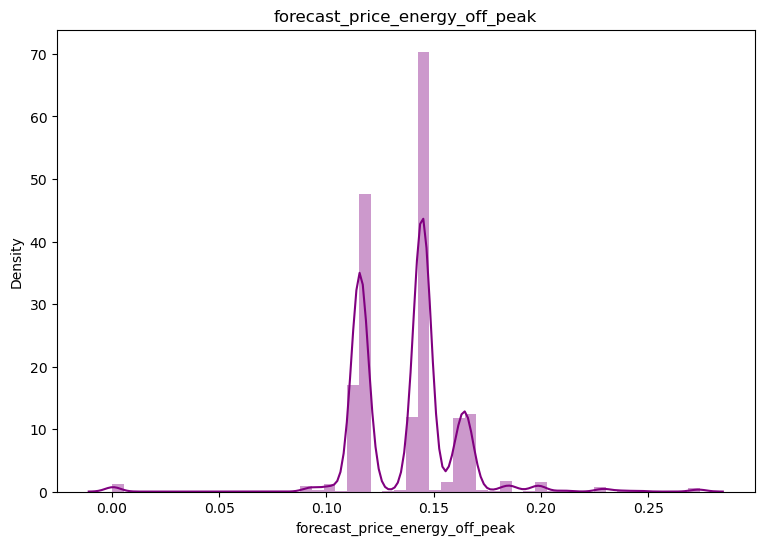

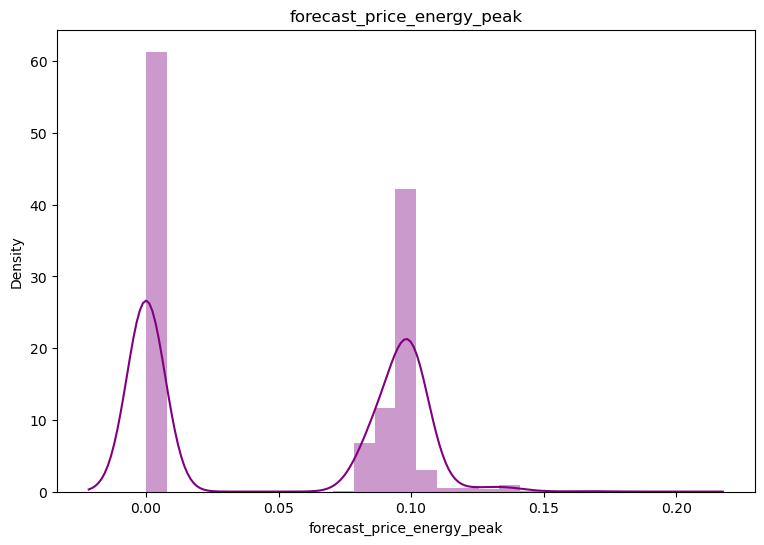

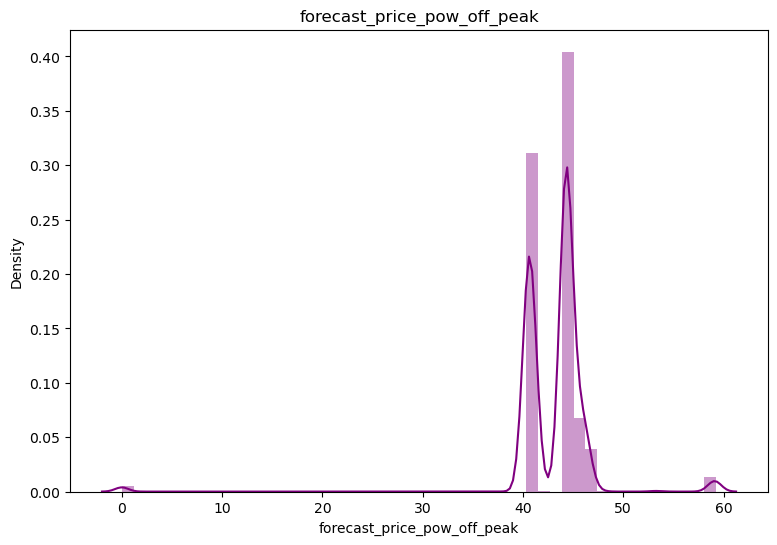

In [87]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax = ax, color="purple")
    ax.set_title(col)
plt.show()

We can see that the standard deviation for most of these features is quite high. Note that we cannot apply log to a value of 0, so we will add a constant of 1 to all the values.

In [89]:
for i in numeric_features:
    df[i]=df[i].apply(lambda x:np.log(1+x))

Let's quickly check the distributions after log transformation.

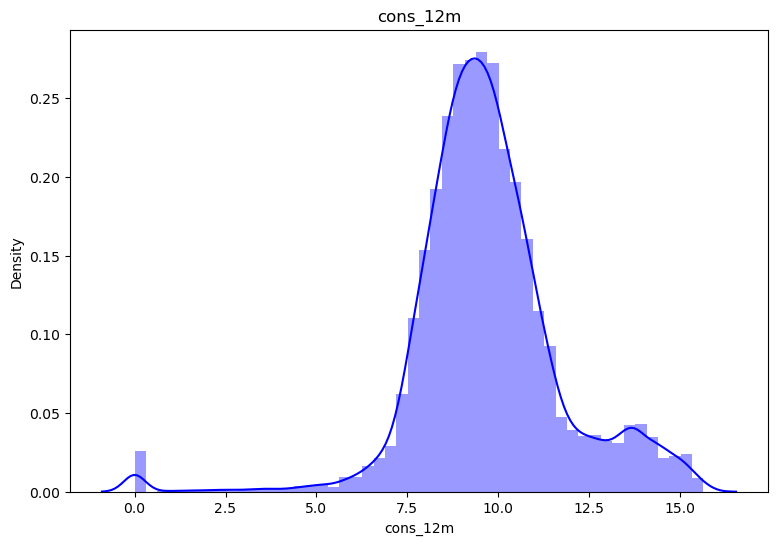

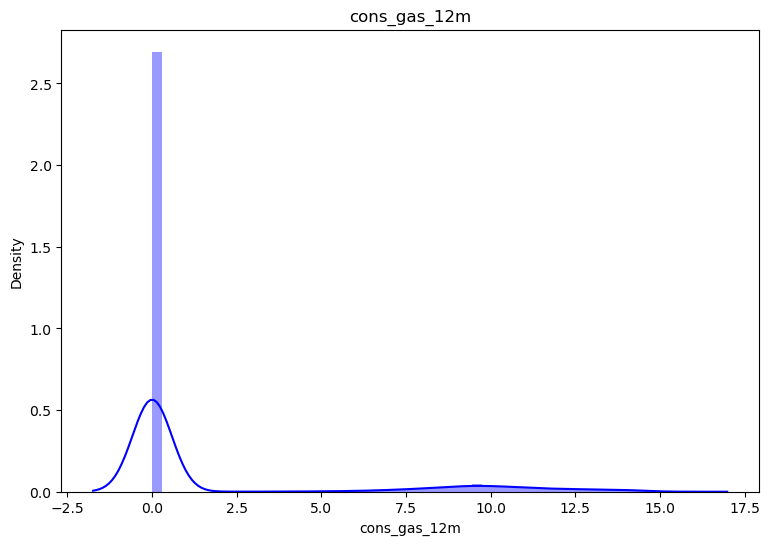

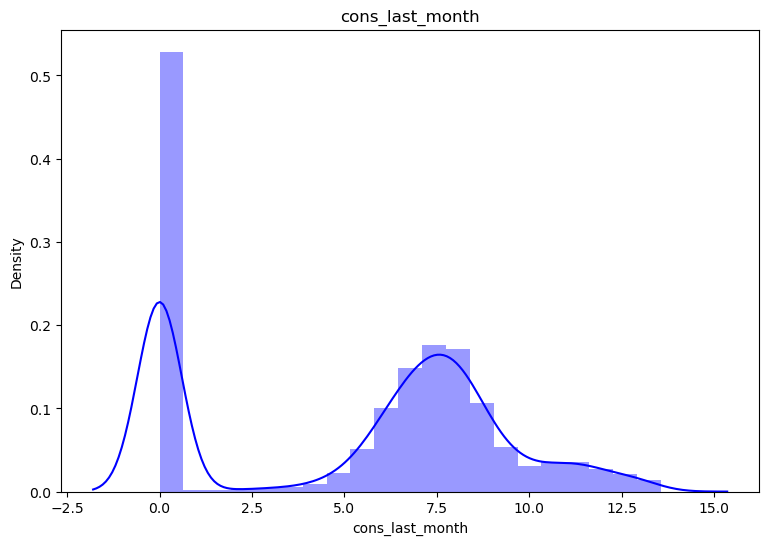

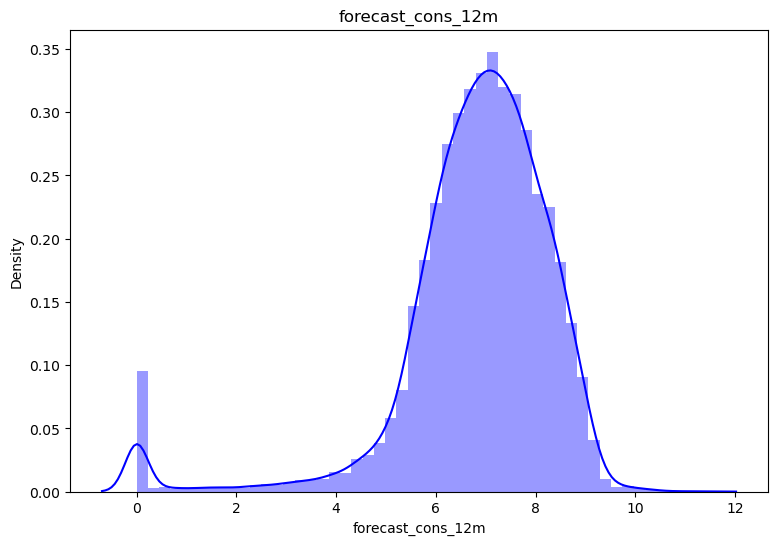

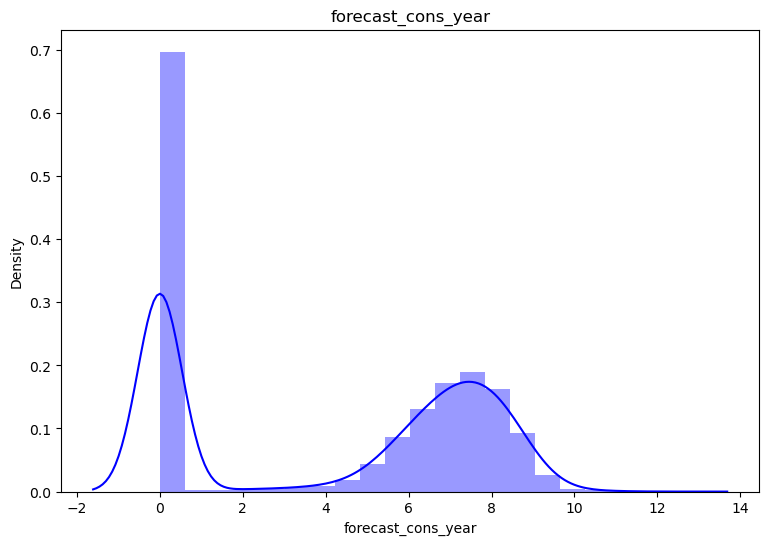

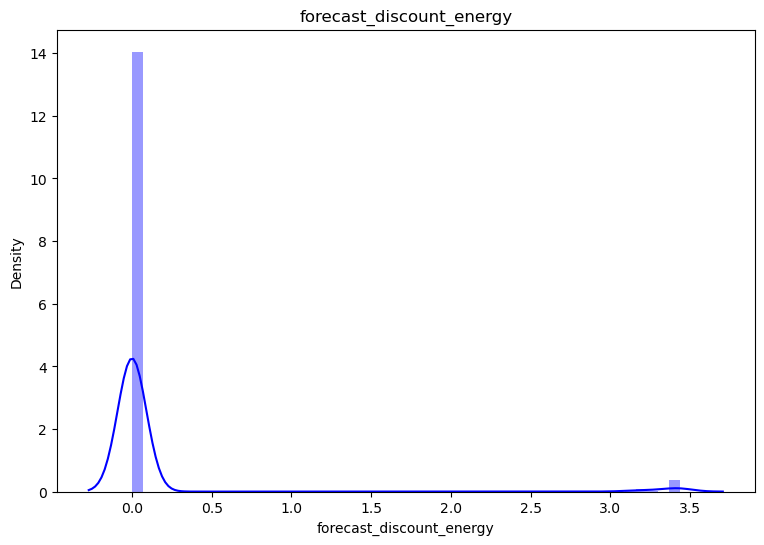

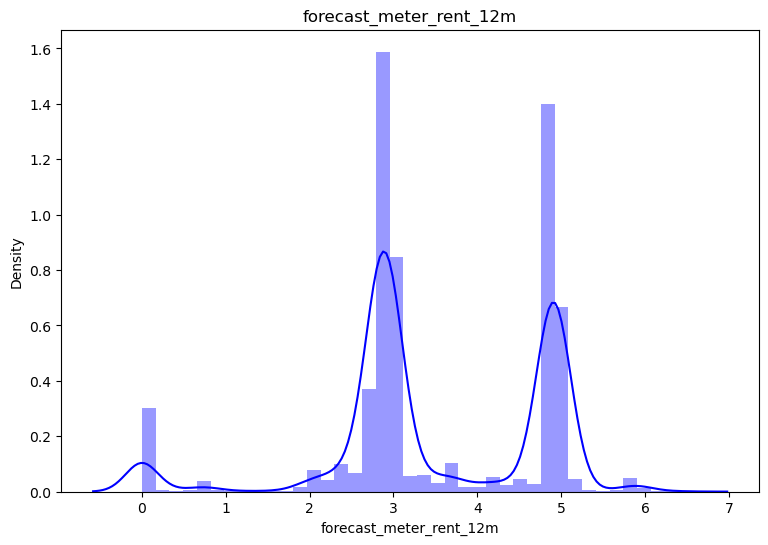

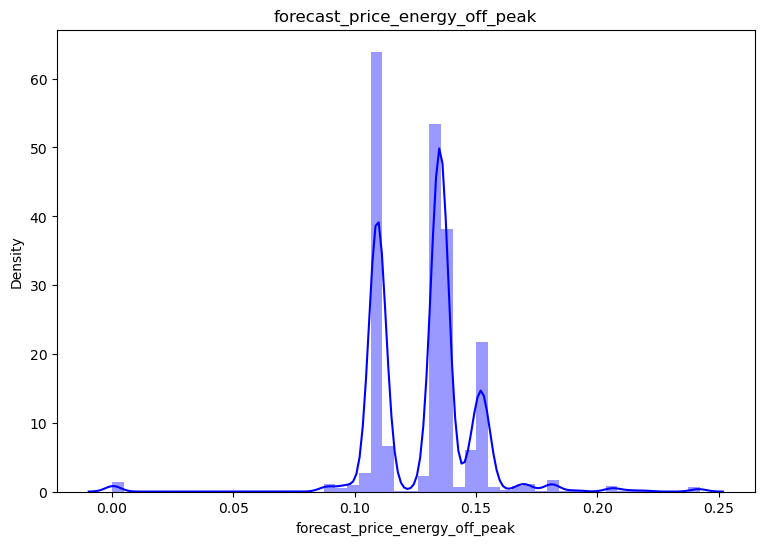

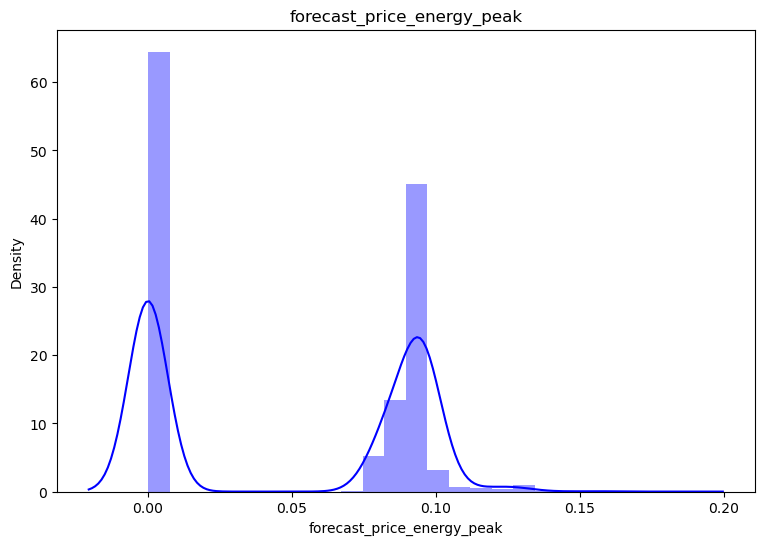

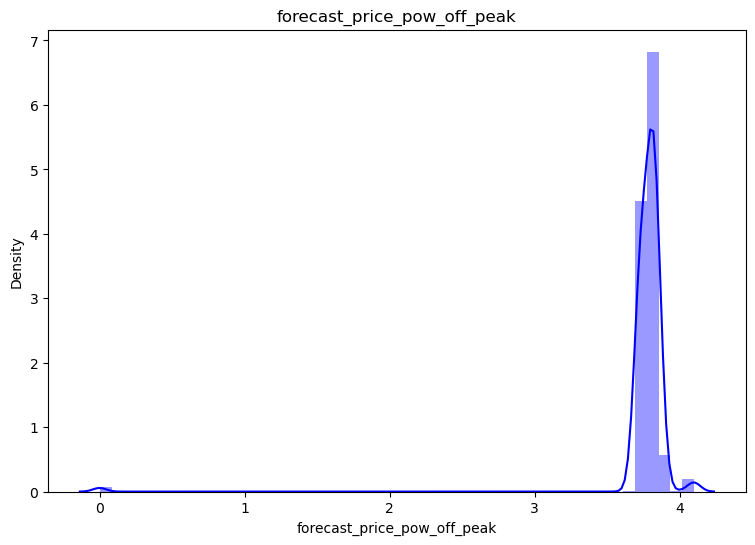

In [91]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax = ax, color="blue")
    ax.set_title(col)
plt.show()

Removing some variables which exhibit a high correlation with other independent features.

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 57 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              14605 non-null  object 
 1   cons_12m                                        14605 non-null  float64
 2   cons_gas_12m                                    14605 non-null  float64
 3   cons_last_month                                 14605 non-null  float64
 4   forecast_cons_12m                               14605 non-null  float64
 5   forecast_cons_year                              14605 non-null  float64
 6   forecast_discount_energy                        14605 non-null  float64
 7   forecast_meter_rent_12m                         14605 non-null  float64
 8   forecast_price_energy_off_peak                  14605 non-null  float64
 9   forecast_price_energy_peak             

In [94]:
df = df.drop(columns=['price_date_x',                                    
   'price_off_peak_var_x',                            
   'price_peak_var_x',                                
   'price_mid_peak_var_x',                            
   'price_off_peak_fix_x',                            
   'price_peak_fix_x','price_date_y','price_date','id','price_mid_peak_fix','price_mid_peak_var','price_mid_peak_fix_y','price_mid_peak_var_y'])

             
        
df.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.022451,0.108389,0.093620,3.728261,...,0.020057,3.700961,False,False,True,False,False,False,False,True
1,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,2.848971,0.136025,0.000000,3.813558,...,-0.003767,0.177779,True,False,False,False,False,True,False,False
2,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,3.681855,0.153402,0.084248,3.813558,...,-0.004670,0.177779,False,False,True,False,False,True,False,False
3,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,3.036394,0.136883,0.000000,3.813558,...,-0.004547,0.177779,False,False,False,True,False,True,False,False
4,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,4.888317,0.110557,0.095324,3.728261,...,-0.006192,0.162916,True,False,False,False,False,True,False,False


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 44 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   cons_12m                                        14605 non-null  float64
 1   cons_gas_12m                                    14605 non-null  float64
 2   cons_last_month                                 14605 non-null  float64
 3   forecast_cons_12m                               14605 non-null  float64
 4   forecast_cons_year                              14605 non-null  float64
 5   forecast_discount_energy                        14605 non-null  float64
 6   forecast_meter_rent_12m                         14605 non-null  float64
 7   forecast_price_energy_off_peak                  14605 non-null  float64
 8   forecast_price_energy_peak                      14605 non-null  float64
 9   forecast_price_pow_off_peak            

## 4. Building Prediction Models

### Split the Data 

We need to split the dataset into training dataset and testing dataset. We will use train_test_slit from sklearn package to split the data into 70% for training and hold back 30% for testing.

In [99]:
# Separate target variable from independent variables
X = df.drop(columns=['churn'])
y = df['churn']

In [100]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 10223
Test cases: 4382


In [101]:
y.value_counts()

churn
0    13186
1     1419
Name: count, dtype: int64

We can see that the number of churn and not churn is imbalanced. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique to solve the this problem

In [103]:
from imblearn.over_sampling import SMOTE

# Random Over Sampling
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [104]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10223, 43)
(10223,)
(4382, 43)
(4382,)


### Logistic Regression

In [106]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print (model)

LogisticRegression(C=100.0, solver='liblinear')


In [107]:
y_pred = model.predict(X_test)

In [108]:
#Let's check the accuracy of the predictions 
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.9094020994979461


In [109]:
#create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred) 
cm

array([[3982,    7],
       [ 390,    3]], dtype=int64)

In [110]:
from sklearn import metrics
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 3
False positives: 7
True negatives: 3982
False negatives: 390



In [111]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3989
           1       0.30      0.01      0.01       393

    accuracy                           0.91      4382
   macro avg       0.61      0.50      0.48      4382
weighted avg       0.86      0.91      0.87      4382



In [112]:
# retrieve the precision_score and recall_score metrics
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, y_pred))
print("Overall Recall:",recall_score(y_test, y_pred))

Overall Precision: 0.3
Overall Recall: 0.007633587786259542


Until now, we've considered the predictions from the model as being either 1 or 0 class labels. Actually, things are a little more complex than that. Statistical machine learning algorithms, like logistic regression, are based on probability; so what actually gets predicted by a binary classifier is the probability that the label is true (P(y)) and the probability that the label is false (1 - P(y)). A threshold value of 0.5 is used to decide whether the predicted label is a 1 (P(y) > 0.5) or a 0 (P(y) <= 0.5). You can use the predict_proba method to see the probability pairs for each case:

In [114]:
y_scores = model.predict_proba(X_test)
print(y_scores[:10])

[[0.86238853 0.13761147]
 [0.92920792 0.07079208]
 [0.91555853 0.08444147]
 [0.91840366 0.08159634]
 [0.75460114 0.24539886]
 [0.88172948 0.11827052]
 [0.94357643 0.05642357]
 [0.93607837 0.06392163]
 [0.91597793 0.08402207]
 [0.88501485 0.11498515]]


The decision to score a prediction as a 1 or a 0 depends on the threshold to which the predicted probabilities are compared. If we were to change the threshold, it would affect the predictions; and therefore change the metrics in the confusion matrix. A common way to evaluate a classifier is to examine the true positive rate (which is another name for recall) and the false positive rate for a range of possible thresholds. These rates are then plotted against all possible thresholds to form a chart known as a received operator characteristic (ROC) chart, like this:

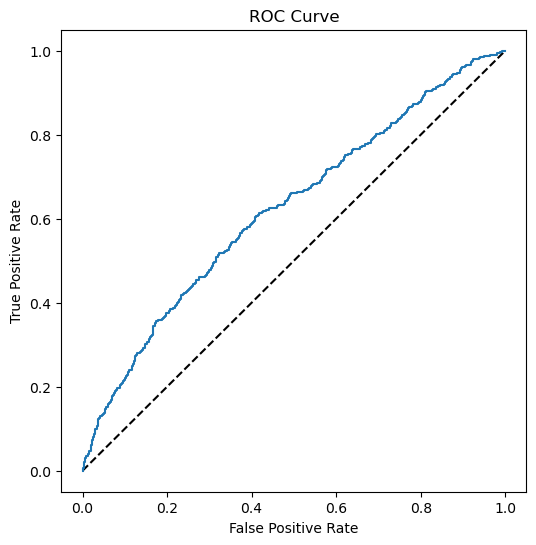

In [116]:
from sklearn.metrics import roc_curve
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC chart shows the curve of the true and false positive rates for different threshold values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the chart represents the probability of predicting correctly with a 50/50 random prediction; so you obviously want the curve to be higher than that (or your model is no better than simply guessing!).

The area under the curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model. Once again, scikit-Learn includes a function to calculate this metric.

In [118]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.6218927751060965


- Looking at the true negatives, we have 3975 out of 3989. This means that out of all the negative cases (churn = 0), we predicted 3981 as negative (hence the name True negative). This is great!
- Looking at the false negatives, this is where we have predicted a client to not churn (churn = 0) when in fact they did churn (churn = 1). This number is too high at 390, but we want to get the false negatives to as close to 0 as we can.
- Looking at false positives, this is where we have predicted a client to churn when they actually didnt churn. For this value we can see there are 14, quite good.
-  With the true positives, we can see that in total we have 393 clients that churned in the test dataset. However, we are only able to correctly identify 0 of those 393, which is very poor.
-  Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.
-  Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.

### Random Forest 

In [121]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators = 1000).fit(X_train, (y_train))
print (model_RF)

RandomForestClassifier(n_estimators=1000)


True positives: 20
False positives: 8
True negatives: 3981
False negatives: 373

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3989
           1       0.71      0.05      0.10       393

    accuracy                           0.91      4382
   macro avg       0.81      0.52      0.52      4382
weighted avg       0.90      0.91      0.88      4382

Accuracy: 0.9130534002738475
Overall Precision: 0.7142857142857143
Overall Recall: 0.05089058524173028

AUC: 0.6814847701407879


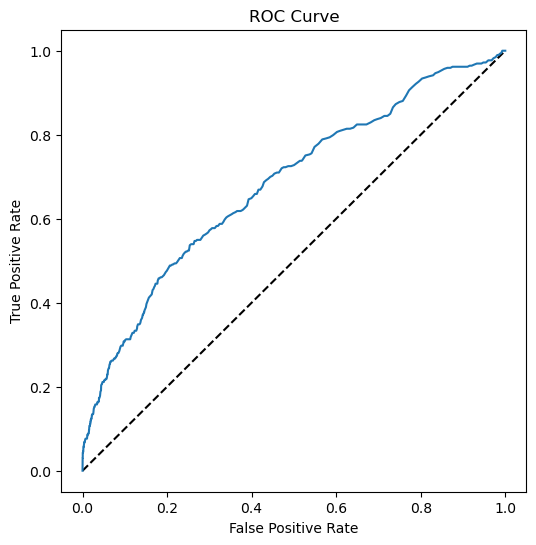

In [122]:
y_pred_RF = model_RF.predict(X_test)
y_scores_RF = model_RF.predict_proba(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_RF).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(classification_report(y_test, y_pred_RF))

print('Accuracy:', accuracy_score(y_test, y_pred_RF))
print("Overall Precision:",precision_score(y_test, y_pred_RF))
print("Overall Recall:",recall_score(y_test, y_pred_RF))
auc = roc_auc_score(y_test,y_scores_RF[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores_RF[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

- Looking at the true negatives, we have 3983 out of 3989. This is great!

- Looking at the false negatives, 372 is too high but better than Logistic Model. 

- Looking at false positives, we can see there are only , quite good. 

- With the true positives, we correctly identify 22 of those 393, which is very poor.

- Looking at the accuracy score, this is very misleading, looking at the precision score and recall score, this shows us a score of 0.78  which is not bad, but could be improved. However, the recall shows us that the classifier has a very poor ability to identify positive samples. This would be the main concern for improving this model!
- The AUC is better a little bit comparing with Logistic Regression.

### Model Understanding

Feature importances indicate the importance of a feature within the predictive model. 

In [125]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_RF.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

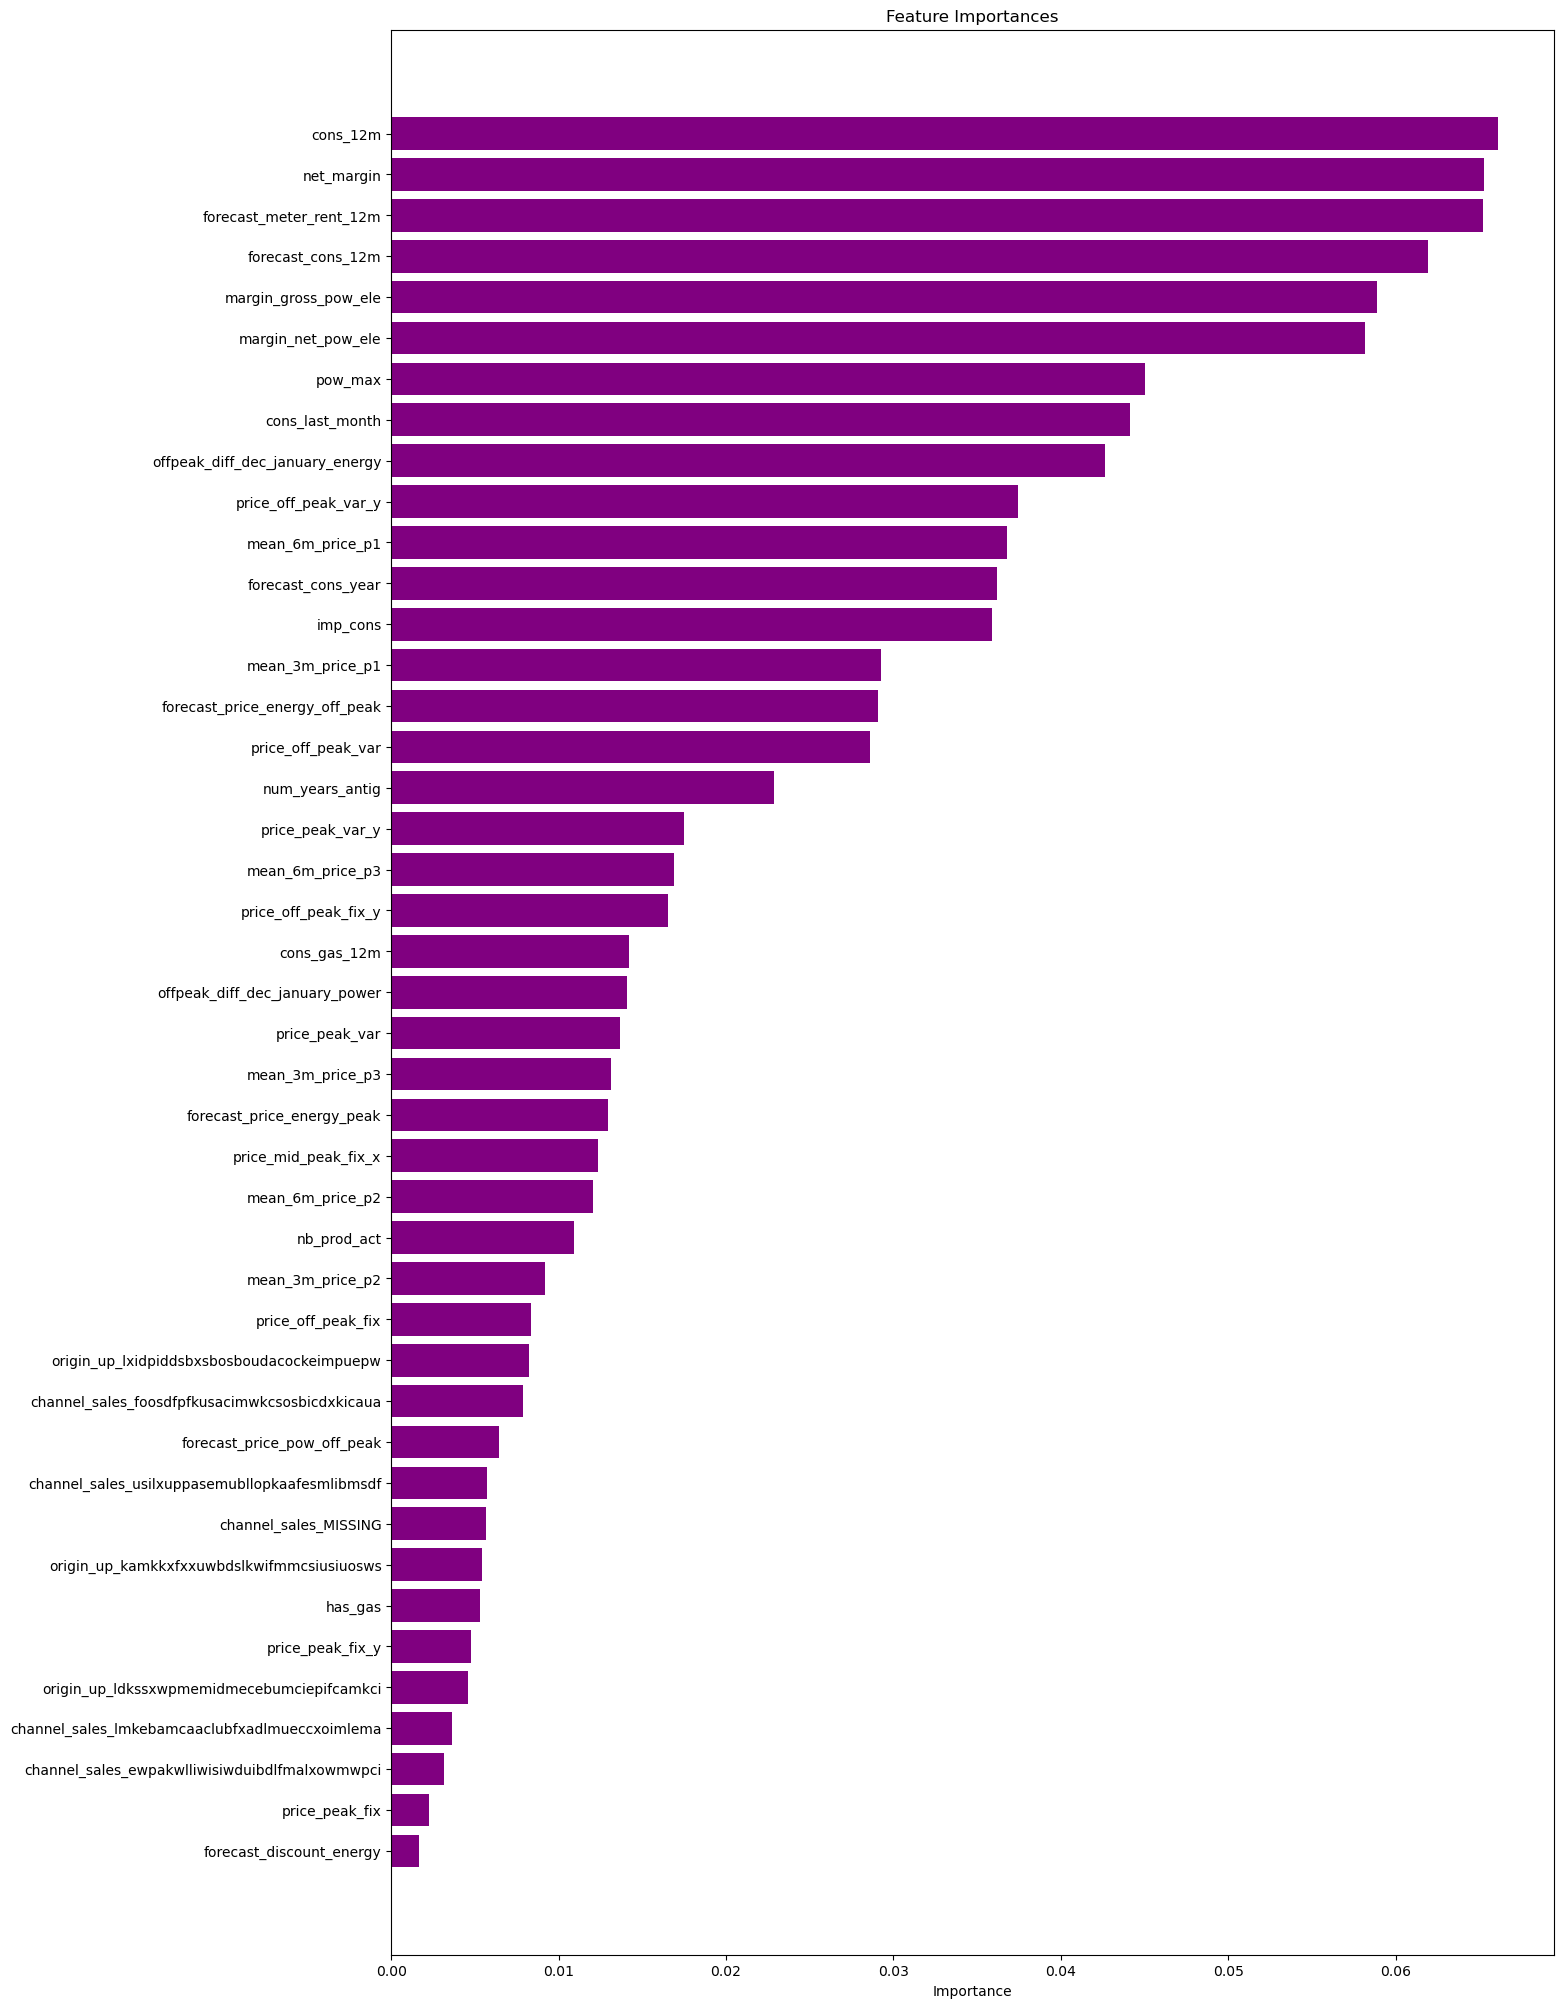

In [127]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='purple', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:

Consumption over 12 months and forecast meter rent 12 month are a top driver for churn in this model
Net margin also plays an important role in the predictive model.
Our price sensitivity features are scattered around but are not the main driver for a customer churning

In [130]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [132]:
y_scores = model_RF.predict_proba(X_test)
probabilities = y_scores[:, 1]

In [133]:
X_test['churn'] = y_pred_RF.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('data_with_predictions.csv')

In [136]:
import joblib

# Save the model as a pickle file
filename = 'powerco_churn_model.pkl'
joblib.dump(model_RF, filename)

['powerco_churn_model.pkl']